<a href="https://colab.research.google.com/github/SoniaBorsi/Adversarial-Attack-GNN/blob/metattack/metattack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libraries

In [ ]:
# !pip uninstall -y torch torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv deeprobust
'''
If import block fails with a numpy size diff, uncomment and run the two lines below. rerun all blocks after.
'''
#!pip uninstall -y numpy
#!pip install numpy==1.23.5

In [ ]:
!pip install numpy==1.23.5 torch==2.0.0 torchvision==0.15.1 torchaudio==2.0.1
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install deeprobust
!pip install networkx matplotlib
!pip install ogb

In [1]:
# Import the required modules
import torch
import torch_geometric
import deeprobust

print("PyTorch Version:", torch.__version__)
print("PyG Installed:", torch_geometric.__version__)

import torch.nn.functional as F
import numpy as np

print("Numpy Installed:", np.__version__)

import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as sparse

PyTorch Version: 2.0.0+cu117
PyG Installed: 2.6.1
Numpy Installed: 1.26.4


In [2]:
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_scipy_sparse_matrix, subgraph
from torch_geometric.data import Data
from torch_sparse import from_scipy

from deeprobust.graph.global_attack import Metattack
print("Metattack Imported Successfully")

# Planetoid: Cora, Citeseer, PubMed
# WebKB: Texas
# PolBlogs: polblogs
# Flickr: Flickr
from torch_geometric.datasets import Planetoid, WebKB, PolBlogs, Flickr
# OGB: ogbn-proteins
from ogb.nodeproppred import PygNodePropPredDataset
from sklearn.metrics import f1_score, precision_score, recall_score

Metattack Imported Successfully


# Load Datasets
Cora, Citeseer, PubMed, Texas, PolBlogs, and Flickr

In [ ]:
'''
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
import os

def subset_graph(data, num_nodes_subset, save_path):
  #Make a subset of a graph if it is too big
  perm = torch.randperm(data.num_nodes)[:num_nodes_subset]
  perm = perm.sort()[0]

  edge_index, _ = subgraph(perm, data.edge_index, relabel_nodes=True)

  x = data.x[perm] if data.x is not None else None
  y = data.y[perm] if data.y is not None else None

  new_data = Data(x=x, edge_index=edge_index, y=y)
  torch.save(new_data, save_path)
  print(f"Saved subset graph to {save_path}")
  return new_data
'''

In [ ]:
# Still failing because using all RAM
'''
import random

def subsample(data, num_nodes):
  node_indices = torch.randperm(data.num_nodes)[:num_nodes]
  edge_index, _ = subgraph(node_indices, data.edge_index, relabel_nodes=True)
  data.x = data.x[node_indices]
  data.y = data.y[node_indices]

  # (Re)define masks
  data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.train_mask[:int(0.6 * num_nodes)] = True

  data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.val_mask[int(0.6 * num_nodes):int(0.8 * num_nodes)] = True

  data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.test_mask[int(0.8 * num_nodes):] = True

  data.edge_index = edge_index
  return data
'''

In [ ]:
# Still failing because uses all RAM

'''
def subsample_ogbn_proteins(dataset, num_nodes=7000):
  full_data = dataset[0]
  sampled_nodes = torch.randperm(full_data.num_nodes)[:num_nodes]

  edge_index, edge_mask = subgraph(sampled_nodes, full_data.edge_index, relabel_nodes=True)
  edge_attr = full_data.edge_attr[edge_mask]

  # Simulate node features if missing
  x = torch.zeros((num_nodes, 1))

  # Subsample y
  y = full_data.y[sampled_nodes]

  # Generate new train/val/test masks
  train_mask = torch.zeros(num_nodes, dtype=torch.bool)
  val_mask = torch.zeros(num_nodes, dtype=torch.bool)
  test_mask = torch.zeros(num_nodes, dtype=torch.bool)

  train_mask[:int(0.6 * num_nodes)] = True
  val_mask[int(0.6 * num_nodes):int(0.8 * num_nodes)] = True
  test_mask[int(0.8 * num_nodes):] = True

  return Data(
      x=x,
      edge_index=edge_index,
      edge_attr=edge_attr,
      y=y,
      train_mask=train_mask,
      val_mask=val_mask,
      test_mask=test_mask,
  )
'''

In [ ]:

def load_dataset(name):
  if name in ["Cora", "Citeseer", "PubMed"]:
    return Planetoid(root=f"./data/{name}", name=name)[0]
  elif name == "Texas":
    return WebKB(root=f"./data/{name}", name=name)[0]
  elif name == "PolBlogs":
    return PolBlogs(root=f"./tmp/polblogs")[0]
  elif name == "ogbn-proteins":
    return PygNodePropPredDataset(root="./data/ogb", name="ogbn-proteins")[0]
  elif name == "Flickr":
    return Flickr(root=f"./data/Flickr")[0]
  else:
    raise ValueError("Dataset not found")

datasets = {
    "Cora": load_dataset("Cora"),
    "Citeseer": load_dataset("Citeseer"),
    "PubMed": load_dataset("PubMed"),
    "PolBlogs": load_dataset("PolBlogs"),
    "Texas": load_dataset("Texas"),
    "ogbn-proteins": load_dataset("ogbn-proteins"),
    "Flickr": load_dataset("Flickr")
}

# Load datasets for all datasets when using ogbn-proteins, flickr, and pubmed
'''
def load_dataset(name):
  if name in ["Cora", "Citeseer", "PubMed"]:
    data = Planetoid(root=f"./data/{name}", name=name)[0]

    if name == "PubMed":
      data = subsample(data, 5000)
    return data

  elif name == "Texas":
    return WebKB(root=f"./data/{name}", name=name)[0]
  elif name == "PolBlogs":
   return PolBlogs(root=f"./tmp/polblogs")[0]
  elif name == "ogbn-proteins":
    dataset = PygNodePropPredDataset(root="./data/ogb", name="ogbn-proteins")
    return subsample_ogbn_proteins(dataset, num_nodes=7000)

  elif name == "Flickr":
    data = Flickr(root=f"./data/Flickr")[0]
    return subsample(data, 5000)
  else:
    raise ValueError("Dataset not found")

datasets = {
    "Cora": load_dataset("Cora"),
    "Citeseer": load_dataset("Citeseer"),
    "PubMed": load_dataset("PubMed"),
    "PolBlogs": load_dataset("PolBlogs"),
    "Texas": load_dataset("Texas"),
    "ogbn-proteins": load_dataset("ogbn-proteins"),
    "Flickr": load_dataset("Flickr")
}
'''

# Define GCN Model

In [4]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        self.gc1 = GCNConv(num_features, hidden_channels)
        self.gc2 = GCNConv(hidden_channels, num_classes)

        self.nfeat = num_features
        self.nclass = num_classes
        self.hidden_sizes = [hidden_channels]
        self.with_relu = True

    @property
    def gc1_weight(self):
        return self.gc1.lin.weight

    @property
    def gc2_weight(self):
        return self.gc2.lin.weight

    @property
    def weight(self):
        return self.gc1.lin.weight

    def forward(self, x, edge_index):
        x = self.gc1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gc2(x, edge_index)
        self.output = x
        return x

# Train GCN Model

In [5]:
def train_model(model, data, epochs=100, lr=0.01, weight_decay=5e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}')

    return model


# Metattack Over All Datasets

In [6]:
def apply_metattack(model, data, num_perturbations):
  # Convert adjacency matrix and features to sparse format
  adj = to_scipy_sparse_matrix(data.edge_index, num_nodes=data.num_nodes).tocsr()
  features = sparse.csr_matrix(data.x.numpy())
  labels = data.y.numpy()

  # Get train and unlabeled indices
  idx_train = data.train_mask.nonzero(as_tuple=True)[0].cpu().numpy()
  idx_unlabeled = (~data.train_mask).nonzero(as_tuple=True)[0].cpu().numpy()

  # Initialize Metattack
  attacker = Metattack(
      model=model,
      nnodes=data.num_nodes,
      attack_structure=True,
      attack_features=False,
      device='cpu'
  )

  # Perform attack
  attacker.attack(
      features,
      adj,
      labels,
      idx_train,
      idx_unlabeled,
      n_perturbations=num_perturbations,
      ll_constraint=False  # This avoids the sparse tensor issue
  )

  # Ensure `modified_adj` and `modified_features` exist and return them
  modified_adj = attacker.modified_adj
  modified_features = attacker.modified_features

  # If Metattack doesn't return features, use the original
  if modified_features is None:
      modified_features = data.x

  return attacker.modified_adj, attacker.modified_features

# Evaluate Model

In [7]:
def evaluate_model(model, data, perturbed_adj, perturbed_features):
  # Check the type of perturbed_adj
  #print(f"perturbed_adj type: {type(perturbed_adj)}")

  # Ensure the adjacency matrix is in sparse COO format
  if not perturbed_adj.is_sparse:
        perturbed_adj = perturbed_adj.to_sparse()

  # Get edge_index directly from the sparse tensor (COO format)
  edge_index = perturbed_adj._indices()

  # Use original features if perturbed ones are not returned
  if perturbed_features is None:
        perturbed_x = data.x
  else:
      if hasattr(perturbed_features, "toarray"):
          perturbed_x = torch.tensor(perturbed_features.toarray(), dtype=torch.float)
      else:
          perturbed_x = perturbed_features

  # Forward pass through the model using the perturbed graph and features
  model.eval()
  with torch.no_grad():
        out = model(perturbed_x, edge_index)

  # Ensure test_mask is correctly sized and boolean
  if data.test_mask.shape[0] != data.num_nodes:
    print(f"Adjusting test_mask size for {data.dataset_name}...")
    # Truncate or adjust the size
    data.test_mask = data.test_mask[:data.num_nodes]

  # Flatten test_mask if it's not 1D
  if len(data.test_mask.shape) > 1:
      data.test_mask = data.test_mask.flatten()

  # Ensure data.test_mask has the correct size and is boolean
  data.test_mask = data.test_mask[:data.num_nodes].to(torch.bool)

  #if len(data.test_mask.shape) == 1:
    # Ensure it is boolean
    #data.test_mask = data.test_mask.to(torch.bool)

  # Check the shapes of predictions and ground truth labels
  print(f"Prediction shape: {out.shape}")
  print(f"test_mask shape: {data.test_mask.shape}")
  print(f"Ground truth labels shape: {data.y.shape}")

  # Ensure data.y has the same size as test_mask
  assert data.y.shape[0] == data.num_nodes, "data.y shape mismatch with num_nodes"

  #pred = out.argmax(dim=1)
  #correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
  #acc = correct / data.test_mask.sum().item()
  pred = out.argmax(dim=1)
  true = data.y[data.test_mask].cpu().numpy()
  pred_labels = pred[data.test_mask].cpu().numpy()

  # Accuracy
  correct = (pred_labels == true).sum().item()
  acc = correct / data.test_mask.sum().item()

  # Precision, recall, F1 score
  precision = precision_score(true, pred_labels, average='macro', zero_division=0)
  recall = recall_score(true, pred_labels, average='macro', zero_division=0)
  f1 = f1_score(true, pred_labels, average='macro', zero_division=0)


  return acc, precision, recall, f1

# Visualization

In [8]:
def visualize_graph(edge_index, title="Graph"):
  if isinstance(edge_index, torch.Tensor):
    edge_index = edge_index.cpu().numpy()

  if edge_index.shape[0] != 2:
    raise ValueError("Expected edge_index shape [2, num_edges]")

  # Convert to list of edge tuples
  edge_list = list(zip(edge_index[0], edge_index[1]))

  G = nx.Graph()
  G.add_edges_from(edge_list)
  plt.figure(figsize=(8, 6))
  nx.draw(G, node_size=30, edge_color="gray", alpha=0.6, with_labels=False)
  plt.title(title)
  plt.show()

# Create Masks

In [9]:
def split_masks(data, train_ratio=0.6, val_ratio=0.2):
  num_nodes = data.num_nodes
  indices = torch.randperm(num_nodes)

  train_size = int(train_ratio * num_nodes)
  val_size = int(val_ratio * num_nodes)

  data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

  data.train_mask[indices[:train_size]] = True
  data.val_mask[indices[train_size:train_size + val_size]] = True
  data.test_mask[indices[train_size + val_size:]] = True

  return data

# Run Experiments

In [12]:
# TODO: make num_perturbations 0.2 * number of edges (once initial experiments run)

def run_experiment(dataset_name):
  dataset = load_dataset(dataset_name)

  if isinstance(dataset, Data):
    # Already a Data object
    data = dataset
  else:
    # Dataset is a list-like object (like Planetoid)
    data = dataset[0]

  if data.x is None:
    # Patching missing features (for PolBlogs, speficially)
    # All zero-features carry no useful info -> poor performance,
    # so each node has a unique identifier (one-hot encoding). GNN can differentiate them based on graph structure + node identity
    print(f"{dataset_name} patching missing features...")
    data.x = torch.eye(data.num_nodes)

  # Check the shape of the masks and labels BEFORE: debug
  #print(f"train_mask shape: {data.train_mask.shape}")
  #print(f"data.y shape: {data.y.shape}")

  if not hasattr(data, 'train_mask') or data.train_mask.shape[0] != data.num_nodes:
    # dataset that doesnt come with masks ie. built-in train/test/val splits
    print(f"{dataset_name} making masks...")
    data = split_masks(data)
  else:
    if len(data.train_mask.shape) > 1:
      # If the train_mask exists but is not 1D, fix it to be
      print(f"Fixing train_mask_shape for {dataset_name}...")
      data.train_mask = data.train_mask.view(-1)

  # check train_mask is correct (Texas)
  if data.train_mask.shape[0] != data.num_nodes:
    print(f"Adjusting train_masks size for {dataset_name}...")
    # Truncate or adjust the size
    data.train_mask = data.train_mask[:data.num_nodes]
  if len(data.train_mask.shape) == 1:
    # Ensure it is boolean
    data.train_mask = data.train_mask.to(torch.bool)

  # Check the shape of the masks and labels AFTER: debug
  #print(f"train_mask shape: {data.train_mask.shape}")
  #print(f"data.y shape: {data.y.shape}")

  num_classes = len(torch.unique(data.y))

  print("=" * 100)
  print(f"Dataset: {dataset_name}")
  print(f"    Number of nodes: {data.num_nodes}")
  print(f"    Number of features: {data.num_features}")
  print(f"    Number of classes: {num_classes}\n")

  model = GCN(data.num_features, 16, num_classes)
  model = train_model(model, data)

  if data.num_nodes <= 5000:
    print("-" * 100)
    print("Original Graph")
    visualize_graph(data.edge_index, title=f"{dataset_name}: Before Metattack")

  #num_perturbations = int(data.edge_index.size(1) * 0.01)
  num_perturbations =5
  print(f"Running on {num_perturbations} perturbations")
  perturbed_adj, perturbed_features = apply_metattack(model, data, num_perturbations=num_perturbations)
  edge_index_perturbed = perturbed_adj.nonzero().t()

  if data.num_nodes <= 5000:
    print("-" * 100)
    print("Perturbed Graph")
    visualize_graph(edge_index_perturbed, title=f"{dataset_name}: After Metattack")

  # Print metrics
  acc, precision, recall, f1 = evaluate_model(model, data, perturbed_adj, perturbed_features)
  print("-" * 100)
  print(f"Evaluation Metrics after Metattack on {dataset_name}:")
  print(f"    Accuracy: {acc:.4f}")
  print(f"    Precision: {precision:.4f}")
  print(f"    Recall   : {recall:.4f}")
  print(f"    F1 Score : {f1:.4f}")


# Execution

Dataset: Cora
    Number of nodes: 2708
    Number of features: 1433
    Number of classes: 7

Epoch 0, Loss: 1.9456
Epoch 10, Loss: 0.7267
Epoch 20, Loss: 0.2171
Epoch 30, Loss: 0.1034
Epoch 40, Loss: 0.0689
Epoch 50, Loss: 0.0452
Epoch 60, Loss: 0.0479
Epoch 70, Loss: 0.0614
Epoch 80, Loss: 0.0336
Epoch 90, Loss: 0.0578
----------------------------------------------------------------------------------------------------
Original Graph


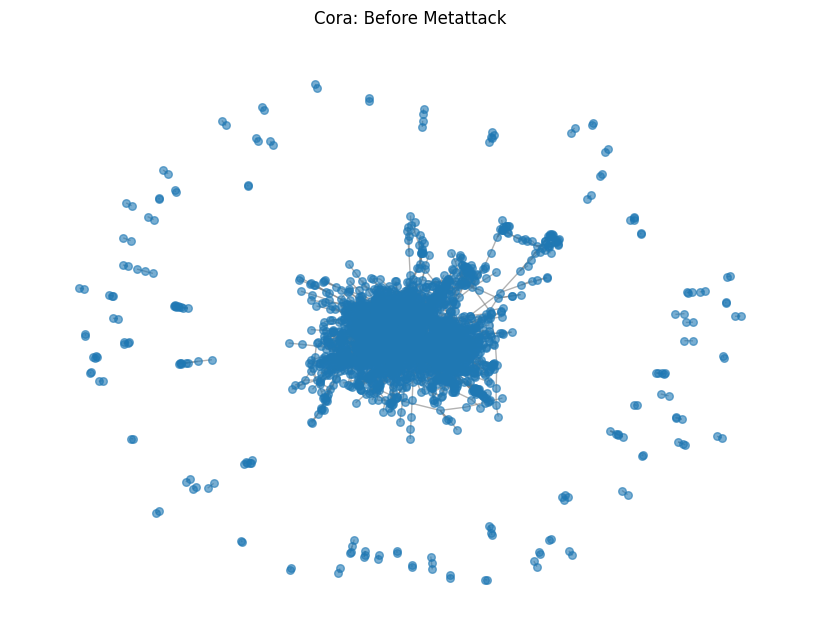

Running on 5 perturbations


Perturbing graph:   0%|          | 0/5 [00:00<?, ?it/s]

GCN loss on unlabled data: 0.6844099760055542
GCN acc on unlabled data: 0.7764797507788161
attack loss: 0.34259581565856934


Perturbing graph:  20%|██        | 1/5 [00:16<01:05, 16.38s/it]

GCN loss on unlabled data: 0.6746065020561218
GCN acc on unlabled data: 0.7772585669781932
attack loss: 0.31207263469696045


Perturbing graph:  40%|████      | 2/5 [00:32<00:48, 16.18s/it]

GCN loss on unlabled data: 0.6850250363349915
GCN acc on unlabled data: 0.7912772585669782
attack loss: 0.33607789874076843


Perturbing graph:  60%|██████    | 3/5 [00:50<00:34, 17.01s/it]

GCN loss on unlabled data: 0.7010893821716309
GCN acc on unlabled data: 0.7718068535825545
attack loss: 0.3546142280101776


Perturbing graph:  80%|████████  | 4/5 [01:06<00:16, 16.49s/it]

GCN loss on unlabled data: 0.7031036615371704
GCN acc on unlabled data: 0.772196261682243
attack loss: 0.34550321102142334


Perturbing graph: 100%|██████████| 5/5 [01:21<00:00, 16.38s/it]


----------------------------------------------------------------------------------------------------
Perturbed Graph


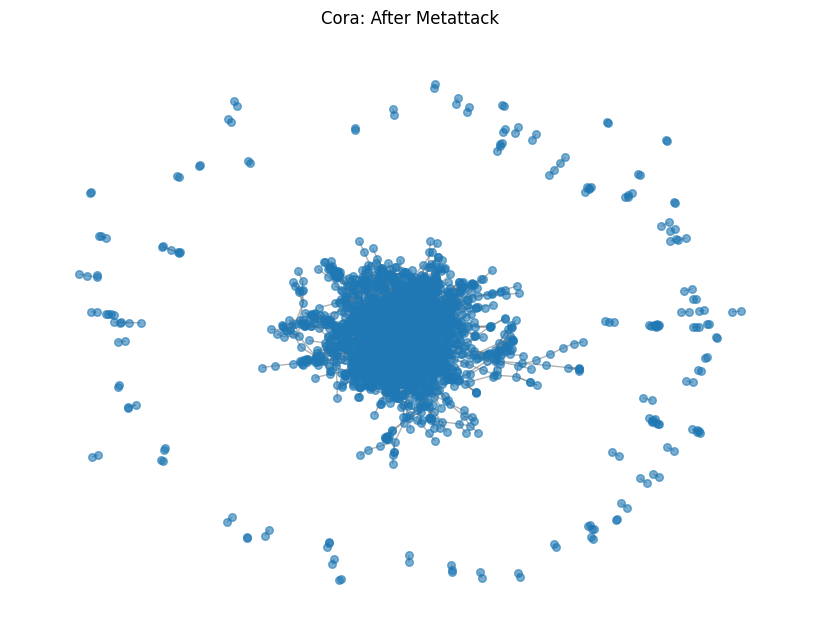

Prediction shape: torch.Size([2708, 7])
test_mask shape: torch.Size([2708])
Ground truth labels shape: torch.Size([2708])
----------------------------------------------------------------------------------------------------
Evaluation Metrics after Metattack on Cora:
    Accuracy: 0.7860
    Precision: 0.7655
    Recall   : 0.8041
    F1 Score : 0.7799
Dataset: Citeseer
    Number of nodes: 3327
    Number of features: 3703
    Number of classes: 6

Epoch 0, Loss: 1.7971
Epoch 10, Loss: 0.4040
Epoch 20, Loss: 0.1198
Epoch 30, Loss: 0.0644
Epoch 40, Loss: 0.0371
Epoch 50, Loss: 0.0400
Epoch 60, Loss: 0.0335
Epoch 70, Loss: 0.0391
Epoch 80, Loss: 0.0689
Epoch 90, Loss: 0.0339
----------------------------------------------------------------------------------------------------
Original Graph


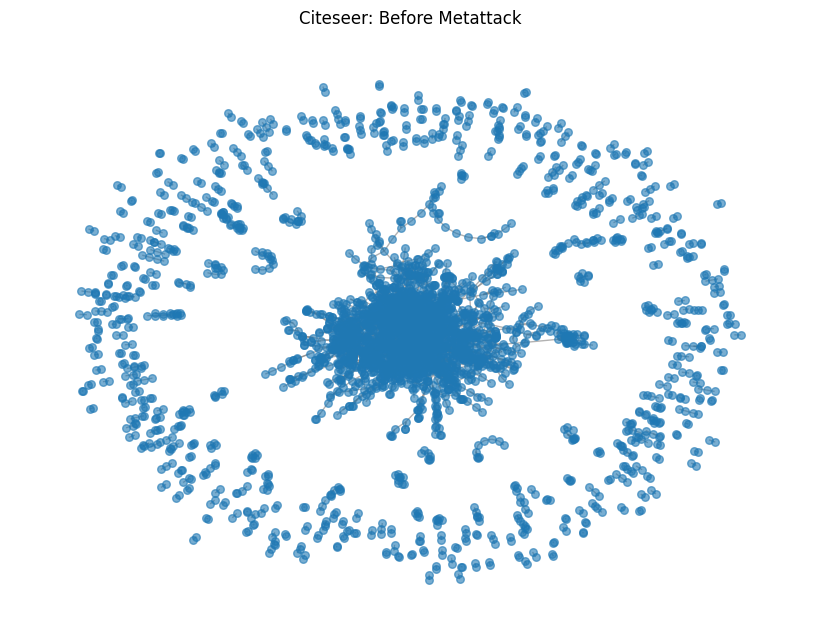

Running on 5 perturbations


Perturbing graph:   0%|          | 0/5 [00:00<?, ?it/s]

GCN loss on unlabled data: 1.3727205991744995
GCN acc on unlabled data: 0.6202057998129092
attack loss: 0.49284979701042175


Perturbing graph:  20%|██        | 1/5 [00:40<02:40, 40.16s/it]

GCN loss on unlabled data: 1.3506934642791748
GCN acc on unlabled data: 0.618334892422825
attack loss: 0.5182404518127441


Perturbing graph:  40%|████      | 2/5 [01:08<01:40, 33.46s/it]

GCN loss on unlabled data: 1.3501778841018677
GCN acc on unlabled data: 0.6192703461178671
attack loss: 0.5276645421981812


Perturbing graph:  60%|██████    | 3/5 [01:48<01:12, 36.27s/it]

GCN loss on unlabled data: 1.275316596031189
GCN acc on unlabled data: 0.6351730589335828
attack loss: 0.5152562260627747


Perturbing graph:  80%|████████  | 4/5 [02:16<00:32, 32.90s/it]

GCN loss on unlabled data: 1.3632092475891113
GCN acc on unlabled data: 0.6030558154038042
attack loss: 0.5184873938560486


Perturbing graph: 100%|██████████| 5/5 [02:55<00:00, 35.00s/it]


----------------------------------------------------------------------------------------------------
Perturbed Graph


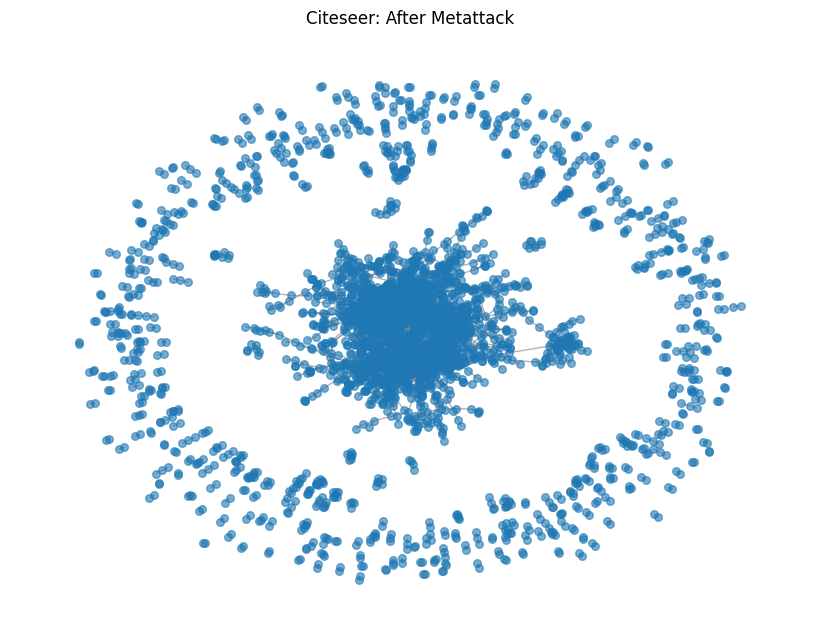

Prediction shape: torch.Size([3327, 6])
test_mask shape: torch.Size([3327])
Ground truth labels shape: torch.Size([3327])
----------------------------------------------------------------------------------------------------
Evaluation Metrics after Metattack on Citeseer:
    Accuracy: 0.6720
    Precision: 0.6494
    Recall   : 0.6467
    F1 Score : 0.6424
PolBlogs patching missing features...
PolBlogs making masks...
Dataset: PolBlogs
    Number of nodes: 1490
    Number of features: 1490
    Number of classes: 2

Epoch 0, Loss: 0.6944
Epoch 10, Loss: 0.4538
Epoch 20, Loss: 0.2454
Epoch 30, Loss: 0.1563
Epoch 40, Loss: 0.1292
Epoch 50, Loss: 0.1179
Epoch 60, Loss: 0.1023
Epoch 70, Loss: 0.1119
Epoch 80, Loss: 0.0995
Epoch 90, Loss: 0.0918
----------------------------------------------------------------------------------------------------
Original Graph


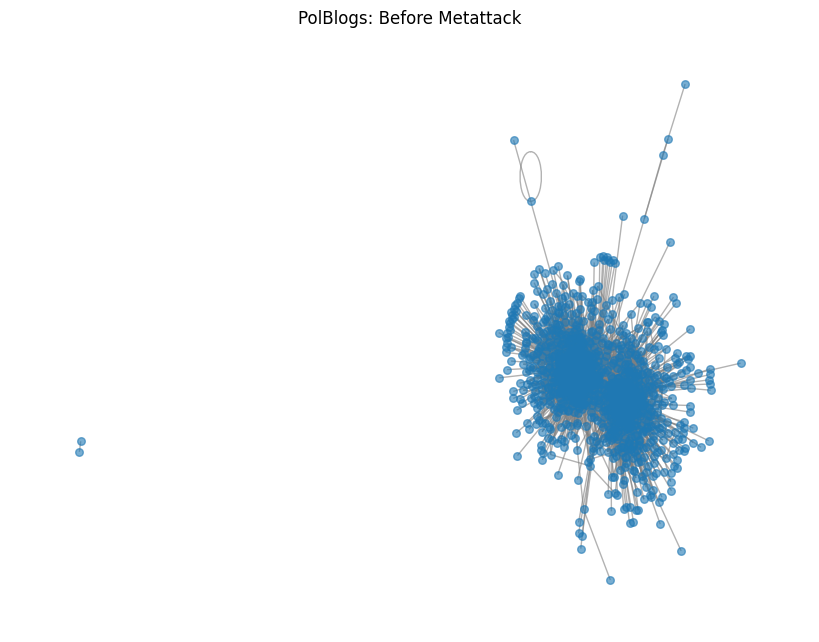

Running on 5 perturbations


Perturbing graph:   0%|          | 0/5 [00:00<?, ?it/s]

GCN loss on unlabled data: 0.44376522302627563
GCN acc on unlabled data: 0.8406040268456376
attack loss: 0.45075011253356934


Perturbing graph:  20%|██        | 1/5 [00:03<00:13,  3.47s/it]

GCN loss on unlabled data: 0.4362139105796814
GCN acc on unlabled data: 0.837248322147651
attack loss: 0.4542871415615082


Perturbing graph:  40%|████      | 2/5 [00:06<00:10,  3.44s/it]

GCN loss on unlabled data: 0.5553256273269653
GCN acc on unlabled data: 0.7734899328859061
attack loss: 0.5576937198638916


Perturbing graph:  60%|██████    | 3/5 [00:11<00:07,  3.88s/it]

GCN loss on unlabled data: 0.47767889499664307
GCN acc on unlabled data: 0.7919463087248322
attack loss: 0.47601795196533203


Perturbing graph:  80%|████████  | 4/5 [00:14<00:03,  3.70s/it]

GCN loss on unlabled data: 0.47482535243034363
GCN acc on unlabled data: 0.7885906040268457
attack loss: 0.4741172194480896


Perturbing graph: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


----------------------------------------------------------------------------------------------------
Perturbed Graph


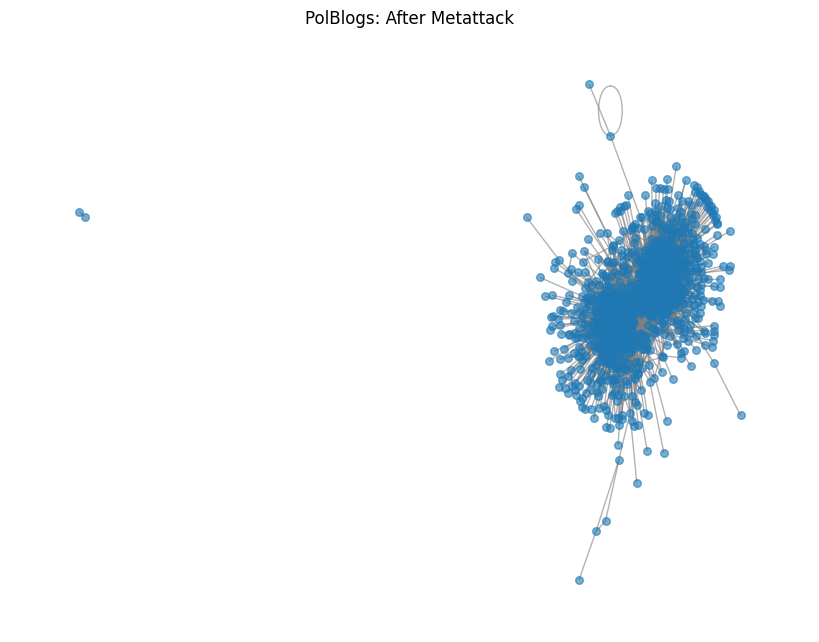

Prediction shape: torch.Size([1490, 2])
test_mask shape: torch.Size([1490])
Ground truth labels shape: torch.Size([1490])
----------------------------------------------------------------------------------------------------
Evaluation Metrics after Metattack on PolBlogs:
    Accuracy: 0.8758
    Precision: 0.8879
    Recall   : 0.8770
    F1 Score : 0.8751
Fixing train_mask_shape for Texas...
Adjusting train_masks size for Texas...
Dataset: Texas
    Number of nodes: 183
    Number of features: 1703
    Number of classes: 5

Epoch 0, Loss: 1.6911
Epoch 10, Loss: 0.8425
Epoch 20, Loss: 0.6277
Epoch 30, Loss: 0.5095
Epoch 40, Loss: 0.4897
Epoch 50, Loss: 0.4611
Epoch 60, Loss: 0.4507
Epoch 70, Loss: 0.4300
Epoch 80, Loss: 0.4649
Epoch 90, Loss: 0.4114
----------------------------------------------------------------------------------------------------
Original Graph


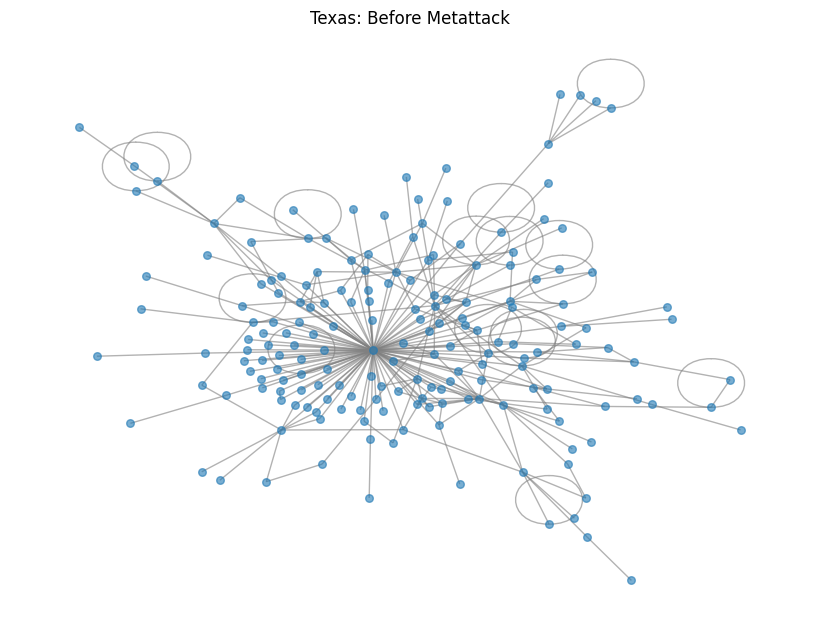

Running on 5 perturbations


Perturbing graph:  20%|██        | 1/5 [00:00<00:01,  2.50it/s]

GCN loss on unlabled data: 6.658846378326416
GCN acc on unlabled data: 0.32978723404255317
attack loss: 4.0930986404418945


Perturbing graph:  40%|████      | 2/5 [00:00<00:01,  2.47it/s]

GCN loss on unlabled data: 5.018096446990967
GCN acc on unlabled data: 0.30851063829787234
attack loss: 2.540623188018799


Perturbing graph:  60%|██████    | 3/5 [00:01<00:00,  2.44it/s]

GCN loss on unlabled data: 5.15924072265625
GCN acc on unlabled data: 0.32978723404255317
attack loss: 2.610137701034546
GCN loss on unlabled data: 5.810358047485352
GCN acc on unlabled data: 0.3191489361702128
attack loss: 3.0605084896087646


Perturbing graph: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

GCN loss on unlabled data: 6.605862140655518
GCN acc on unlabled data: 0.23404255319148937
attack loss: 2.70666766166687
----------------------------------------------------------------------------------------------------
Perturbed Graph


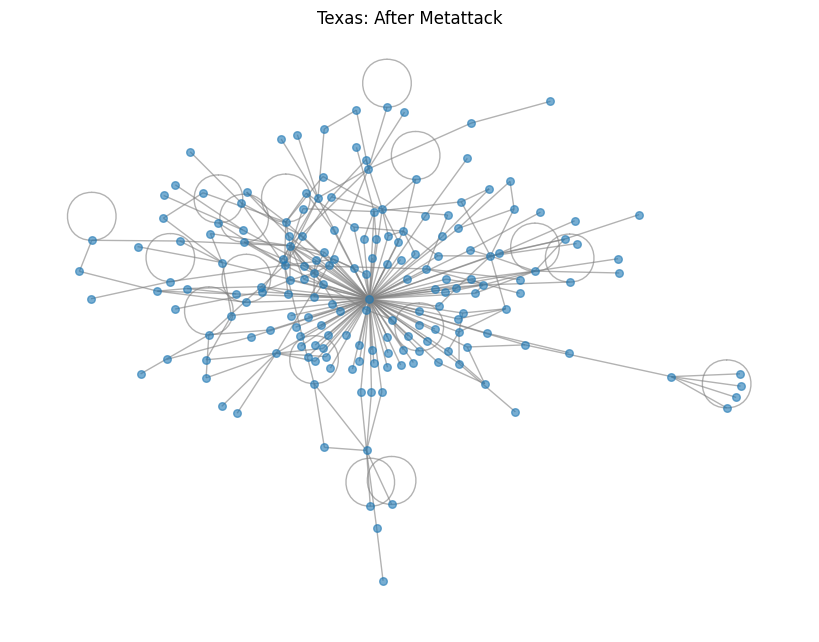

Prediction shape: torch.Size([183, 5])
test_mask shape: torch.Size([183])
Ground truth labels shape: torch.Size([183])
----------------------------------------------------------------------------------------------------
Evaluation Metrics after Metattack on Texas:
    Accuracy: 0.4444
    Precision: 0.2650
    Recall   : 0.3392
    F1 Score : 0.2955


In [13]:
# all datasets, uncomment when debugged all
#datasets = ["Cora", "Citeseer", "PolBlogs", "Texas", "Flickr", "PubMed", "ogbn-proteins"]

# Base code these datasets run
datasets = ["Cora", "Citeseer", "PolBlogs", "Texas"]
# These datasets crash - reason: too big, use all available RAM
#datasets = [ "ogbn-proteins", "Flickr", "PubMed"]

for dataset_name in datasets:
  run_experiment(dataset_name)